# Домашнее задание 2 (продвинутое)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')

# Задание

Ваша задада - научиться предсказывать рейтинг (тональность) отзывов к фильмам Amazon


Загрузите текстовые данные [отсюда](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/). Архив должен содержать 3 файла с положительными и отрицательными отзывами с ресурсов
* imdb.com
* amazon.com
* yelp.com

Формат файла следующий:
<отзыв>\t<метка>\n


### Задача
1. Загрузите тексты и метки классов в разные переменные
2. Мера качества классификации - accuracy
3. Обучите линейный SVM (без подбора гиперпараметров). Тексты представляются в виде мешка слов
4. Выведите наиболее значимые слова из текста
5. С помощью кросс-валидации и валидационных кривых исследуйте, как различные комбинции параметров влияют на качество
6. Сравните с другими линейными методами классификации
7. Визуализируйте обучающую выборку и предсказания классификатора с помощью PCA и (или) t-SNE

# Подсказки (бейслайн)

In [4]:
ls ./sentiment\ labelled\ sentences

ls: ./sentiment labelled sentences: No such file or directory


## Загрузите тексты и метки классов в разные переменные

In [5]:
'''
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015
Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment, extracted from reviews of products, movies, and restaurants

=======
Format:
=======
sentence \t score \n


=======
Details:
=======
Score is either 1 (for positive) or 0 (for negative)	
The sentences come from three different websites/fields:

imdb.com
amazon.com
yelp.com

For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews. 
We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.



For the full datasets look:

imdb: Maas et. al., 2011 'Learning word vectors for sentiment analysis'
amazon: McAuley et. al., 2013 'Hidden factors and hidden topics: Understanding rating dimensions with review text'
yelp: Yelp dataset challenge http://www.yelp.com/dataset_challenge
'''

files = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
texts, labels = [], []

# Сливаем все отзывы в texts
# Сливаем всю разметку по тональности в labels

for file in files:
    with open('./sentiment labelled sentences/' + file) as f:
        data = f.readlines()
        data = [i.strip('\n').split('\t') for i in data]
        for i in data:
            texts.append(i[0])
            labels.append(i[1])

FileNotFoundError: [Errno 2] No such file or directory: './sentiment labelled sentences/amazon_cells_labelled.txt'

# Разобъем на тестовую и валидационную выборку

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, train_size=0.85)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Обучите линейный SVM (без подбора гиперпараметров). Тексты представляются в виде мешка слов

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from mlxtend.preprocessing import DenseTransformer
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


model = Pipeline(
[
    ('vect', TfidfVectorizer()), # Позволяет преобразовать текст в набор признаков, в значении каждого из которых стоит нормированная на число документов частота соответствующего слова
    ('dense', DenseTransformer()), # TfidfVectorizer возвращает SparseMatrix. Нам нужно преобразовать её в Dense, чтобы передать классификатору
    ('svm', SVC(kernel='linear')) # Функция потерь встроена
])

In [52]:
model.fit(texts, labels)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

# Мера качества классификации - accuracy

In [53]:
# Оценим по заявленной метрике качество
# ФУНКЦИОНАЛ КАЧЕСТВА
from sklearn.metrics import accuracy_score
model_test_predictions = model.predict(X_test)
accuracy_score(model_test_predictions, y_test)

0.9716666666666667

# Выведите наиболее значимые слова из текста

In [54]:
# объедим названия признаков и их важность в один список методом zip, 
# отсортируем в порядке возрастания коэффициентов до 10
feature_importances = list(sorted(zip(texts, model.steps[2][1].coef_.squeeze()), key=lambda x: -abs(x[1]))) 
pd.DataFrame(feature_importances, columns=['feature_name', 'feature_importance'])[:10]

,feature_name,feature_importance
0,I could care less... The interior is just beau...,4.049665
1,It looked like a wonderful story.,3.198857
2,The worst phone I've ever had.... Only had it ...,-3.112951
3,No buyers remorse on this one!.,2.516167
4,"That said, our mouths and bellies were still q...",2.477493
5,Not my thing.,2.210597
6,The movie I received was a great quality film ...,2.185091
7,All in all I think it was a good investment.,2.159118
8,What is even more stupid is that who had thoug...,2.150116
9,WELL IM SATISFIED.,-2.129325


# С помощью кросс-валидации и валидационных кривых исследуйте, как различные комбинции параметров влияют на качество

In [56]:
model = Pipeline(
[
    ('vect', TfidfVectorizer()), # Позволяет преобразовать текст в набор признаков, в значении каждого из которых стоит нормированная на число документов частота соответствующего слова
    ('dense', DenseTransformer()), # TfidfVectorizer возвращает SparseMatrix. Нам нужно преобразовать её в Dense, чтобы передать классификатору
    ('svm', SVC())
])

In [68]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'dense', 'svm', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__norm', 'vect__preprocessor', 'vect__smooth_idf', 'vect__stop_words', 'vect__strip_accents', 'vect__sublinear_tf', 'vect__token_pattern', 'vect__tokenizer', 'vect__use_idf', 'vect__vocabulary', 'dense__return_copy', 'svm__C', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "vect__norm": ['l1', 'l2'],
    "svm__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__decision_function_shape": ['ovo', 'ovr'] 
    }

grid = GridSearchCV(model, param_grid, cv=4)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.82


In [79]:
grid.best_params_

{'svm__decision_function_shape': 'ovo',
 'svm__kernel': 'linear',
 'vect__norm': 'l2'}

In [83]:
model = Pipeline(
[
    ('vect', TfidfVectorizer(norm='l2')), # Позволяет преобразовать текст в набор признаков, в значении каждого из которых стоит нормированная на число документов частота соответствующего слова
    ('dense', DenseTransformer()), # TfidfVectorizer возвращает SparseMatrix. Нам нужно преобразовать её в Dense, чтобы передать классификатору
    ('svm', SVC(kernel='linear', decision_function_shape='ovo')) # Функция потерь встроена
])

In [93]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Range of values for parameter
c = [1, 10, 100, 1000]

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(model, 
                                             X_train, 
                                             y_train,
                                             param_name="svm__C", 
                                             param_range=c,
                                             cv=4, 
                                             scoring="accuracy")

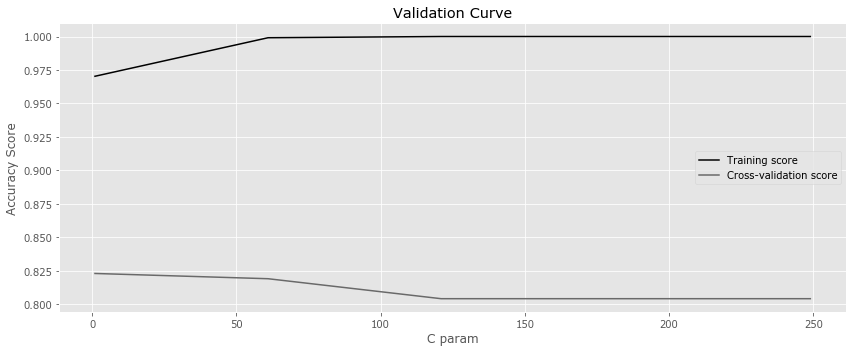

In [146]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot([1, 61, 121, 249], train_mean,  label="Training score", color="black")
plt.plot([1, 61, 121, 249], test_mean,  label="Cross-validation score", color="dimgrey")

# Create plot
plt.title("Validation Curve")
plt.xlabel("C param")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()